In [1]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/g300046/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/g300046/levante-spawner-preset//proxy/8787/status,Workers: 16
Total threads: 256,Total memory: 235.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38777,Workers: 16
Dashboard: /user/g300046/levante-spawner-preset//proxy/8787/status,Total threads: 256
Started: Just now,Total memory: 235.37 GiB
Comm: tcp://127.0.0.1:39415,Total threads: 16
Dashboard: /user/g300046/levante-spawner-preset//proxy/44457/status,Memory: 14.71 GiB
Nanny: tcp://127.0.0.1:35623,


In [28]:
from pyresample.geometry import AreaDefinition
from pyproj import CRS
import cordex as cx
import numpy as np

def cordex_area_def(domain_id):
    ds = cx.cordex_domain(domain_id)
    area_id = domain_id
    description = domain_id
    proj_id = domain_id
    try:
        crs = CRS.from_cf(ds.cf["grid_mapping"].attrs)
    except:
        crs = CRS("EPSG:4326")
    width = ds.cf["X"].size
    height = ds.cf["Y"].size
    area_extent = (
        ds.cf["X"][0].item(),
        ds.cf["Y"][0].item(),
        ds.cf["X"][-1].item(),
        ds.cf["Y"][-1].item(),
    )
    if crs.to_dict()['proj'] == "ob_tran":
        area_extent = tuple(map(np.deg2rad, area_extent))
    return AreaDefinition(
        area_id, description, proj_id, crs, width, height, area_extent
    )

In [33]:
area_def = cordex_area_def("EUR-11")

/work/ch0636/g300046/conda_envs/pangeo/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [30]:
from pyresample.geometry import AreaDefinition, DynamicAreaDefinition
from pyresample import image, geometry
from pyresample.bucket import BucketResampler
import cordex as cx
from pyproj import CRS
import xarray as xr
import numpy as np

area_id = "glcc_igh"
description = "GLCC global"
proj_id = "glcc_igh"
# projection = {'proj': 'laea', 'lat_0': -90, 'lon_0': 0, 'a': 6371228.0, 'units': 'm'}
projection = "+proj=igh +lon_0=0 +x_0=0 +y_0=0 +ellps=sphere +units=m +no_defs=True"
width = 40031
height = 17347
area_extent = (-20015000.0, -8673000.0, 20015000.0, 8673000.0)
glcc_igh = AreaDefinition(
    area_id, description, proj_id, projection, width, height, area_extent
)

In [31]:
glcc = xr.open_dataset(
    "/work/ch0636/g300046/glcc/glccgbg20_tif/gbogeg20.nc", chunks={"x": 4010, "y": 1738}
)
glcc

<xarray.Dataset>
Dimensions:         (y: 17347, x: 40031, index: 98, bounds: 2, vertices: 4)
Coordinates:
  * x               (x) float64 -2.002e+07 -2.001e+07 ... 2.001e+07 2.002e+07
  * y               (y) float64 -8.673e+06 -8.672e+06 ... 8.672e+06 8.673e+06
  * index           (index) int64 0 1 2 3 4 5 6 7 8 ... 90 91 92 93 94 95 96 100
    classification  (index) object dask.array<chunksize=(98,), meta=np.ndarray>
    lon             (y, x) float64 dask.array<chunksize=(1738, 4010), meta=np.ndarray>
    lat             (y, x) float64 dask.array<chunksize=(1738, 4010), meta=np.ndarray>
    y_bounds        (y, bounds) float64 dask.array<chunksize=(1738, 2), meta=np.ndarray>
    x_bounds        (x, bounds) float64 dask.array<chunksize=(4010, 2), meta=np.ndarray>
    lon_bounds      (y, x, vertices) float64 dask.array<chunksize=(1738, 4010, 4), meta=np.ndarray>
    lat_bounds      (y, x, vertices) float64 dask.array<chunksize=(1738, 4010, 4), meta=np.ndarray>
Dimensions without coordinates: bounds, vertices
Data variables:
    glcc            (y, x) uint8 dask.array<chunksize=(1738, 4010), meta=np.ndarray>
Attributes:
    description:  Global Land Cover Characteristics Data Base Version 2.0.
    proj4:        +proj=igh +lon_0=0 +x_0=0 +y_0=0 +ellps=sphere +units=m +no...

In [32]:
lons = glcc.lon.data
lats = glcc.lat.data

In [34]:
resampler = BucketResampler(area_def, lons, lats)

/work/ch0636/g300046/conda_envs/pangeo/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [89]:
urban = [1]
forest = [3, 4, 5, 6]
# forest = list({k: v for k, v in type_dict.items() if "Forest" in v}.keys())
water = [14, 15]
grassland = [7, 8, 9, 10]

classes = urban + water + grassland + forest
classes = list(glcc.index.data)

In [91]:
data = xr.where(glcc.glcc.isin(classes), glcc.glcc, 0).data
data = glcc.glcc.data
data

dask.array<open_dataset-4afa511453dc8934943c711cd431f2f0glcc, shape=(17347, 40031), dtype=uint8, chunksize=(1738, 4010), chunktype=numpy.ndarray>

In [92]:
fractions = resampler.get_fractions(data, categories=classes)

In [93]:
classes = glcc.classification.load()

In [94]:
data_vars = {
    classes.sel(index=i).item().replace(" ", "_"): (["rlat", "rlon"], np.flipud(fractions[i]))
    for i in fractions
}

In [95]:
bodlib = xr.Dataset(data_vars=data_vars)
bodlib

<xarray.Dataset>
Dimensions:                                                  (rlat: 412,
                                                              rlon: 424)
Dimensions without coordinates: rlat, rlon
Data variables: (12/97)
    INTERRUPTED_AREAS_(GLOBAL_GOODES_HOMOLOSINE_PROJECTION)  (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    URBAN                                                    (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    LOW_SPARSE_GRASSLAND                                     (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    CONIFEROUS_FOREST                                        (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    DECIDUOUS_CONIFER_FOREST                                 (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    DECIDUOUS_BROADLEAF_FOREST                               (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    ...                                                       ...
    BROADLEAF_CROPS                                          (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    GRASS_CROPS                                              (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    CROPS,_GRASS,_SHRUBS                                     (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    EVERGREEN_TREE_CROP                                      (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    DECIDUOUS_TREE_CROP                                      (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    NO_DATA                                                  (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>

In [96]:
%time bodlib_ = bodlib.compute()

CPU times: user 4min 47s, sys: 22.8 s, total: 5min 10s
Wall time: 10min 55s


In [97]:
bodlib_

<xarray.Dataset>
Dimensions:                                                  (rlat: 412,
                                                              rlon: 424)
Dimensions without coordinates: rlat, rlon
Data variables: (12/97)
    INTERRUPTED_AREAS_(GLOBAL_GOODES_HOMOLOSINE_PROJECTION)  (rlat, rlon) float64 ...
    URBAN                                                    (rlat, rlon) float64 ...
    LOW_SPARSE_GRASSLAND                                     (rlat, rlon) float64 ...
    CONIFEROUS_FOREST                                        (rlat, rlon) float64 ...
    DECIDUOUS_CONIFER_FOREST                                 (rlat, rlon) float64 ...
    DECIDUOUS_BROADLEAF_FOREST                               (rlat, rlon) float64 ...
    ...                                                       ...
    BROADLEAF_CROPS                                          (rlat, rlon) float64 ...
    GRASS_CROPS                                              (rlat, rlon) float64 ...
    CROPS,_GRASS,_SHRUBS                                     (rlat, rlon) float64 ...
    EVERGREEN_TREE_CROP                                      (rlat, rlon) float64 ...
    DECIDUOUS_TREE_CROP                                      (rlat, rlon) float64 ...
    NO_DATA                                                  (rlat, rlon) float64 ...

In [98]:
classes = xr.concat([bodlib_[var] for var in bodlib_.data_vars], dim=xr.DataArray(list(bodlib_.data_vars), dims="class"))

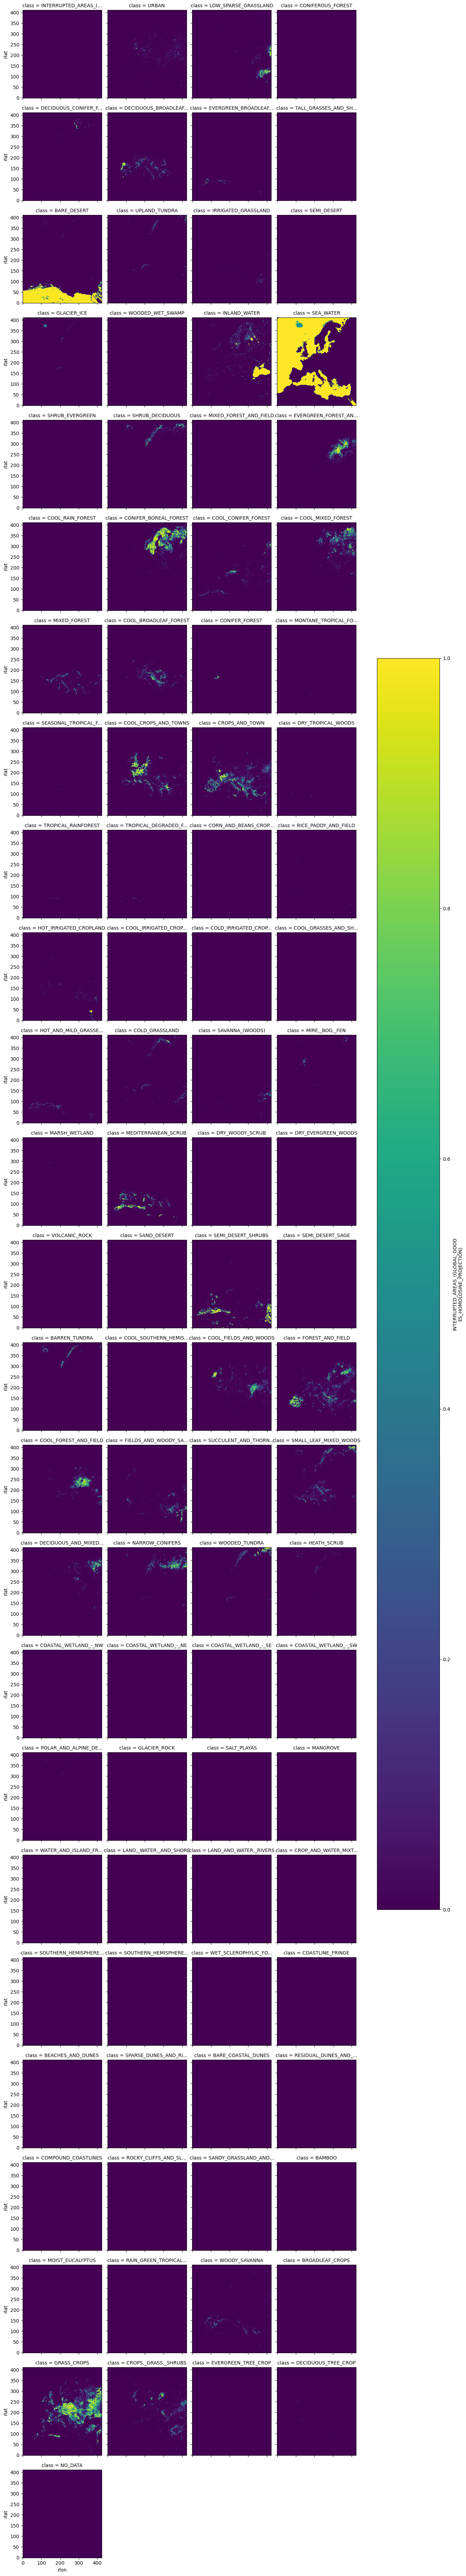

In [99]:
classes.plot(col="class", col_wrap=4)

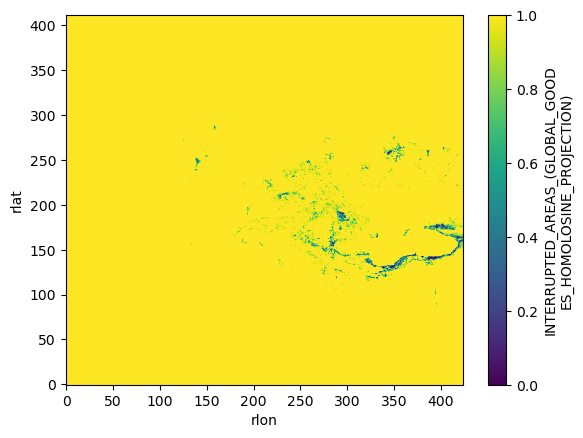

In [100]:
classes.sum("class").plot()